In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import torch
from itertools import chain, combinations
import l0learn
import l0bnb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import sys
import os
sys.path.append("..")
print(os.getcwd())
print(sys.path)
from interpretDistill.fourierDistill import FTDistill, FTDistillCV
from experiments.binary_experiment_MLP import MLP

/home/mattyshen/interpretableDistillation/experiments
['/home/mattyshen/interpretableDistillation/experiments', '/home/mattyshen/anaconda3/lib/python39.zip', '/home/mattyshen/anaconda3/lib/python3.9', '/home/mattyshen/anaconda3/lib/python3.9/lib-dynload', '', '/home/mattyshen/anaconda3/lib/python3.9/site-packages', '..']


In [2]:
np.random.seed(42)
n_samples = 100000
X1 = np.random.choice([1, -1], size=n_samples, p=[0.7, 0.3])
X2 = np.random.choice([1, -1], size=n_samples, p=[0.4, 0.6])
X3 = np.random.choice([1, -1], size=n_samples, p=[0.9, 0.1])

probabilities = np.random.uniform(0.3, 0.7, size=3)
print(probabilities)
X4_to_X6 = []
for p in probabilities:
    X = np.random.choice([1, -1], size=n_samples, p=[p, 1-p])
    X4_to_X6.append(X)

X4_to_X6 = np.column_stack(X4_to_X6)

X = np.column_stack((X1, X2, X3, X4_to_X6))
eps = np.random.normal(0, 1, size=n_samples)

Y = X1 * np.sin(X1) + 2*X2 * X3 + eps

X = pd.DataFrame(X, columns = [f'X{i}' for i in range(1, 7)])
Y = pd.Series(Y, name = 'Y')

[0.36282159 0.33820351 0.35517568]


In [18]:
XY = pd.concat([X, Y], axis = 1)
Xy1 = XY[XY['Y'] <= np.percentile(Y, 67)]
Xy2 = XY[XY['Y'] > np.percentile(Y, 67)]

In [20]:
#X_train1, X_test1, y_train1, y_test1 = train_test_split(Xy1.drop(columns = ['Y']), Xy1['Y'], test_size=0.33, shuffle = True,random_state=42)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(Xy2.drop(columns = ['Y']), Xy2['Y'], test_size=0.33, shuffle=True, random_state=42)
# X_train = pd.concat([X_train1, X_train2], axis=0)
# y_train = pd.concat([y_train1, y_train2], axis=0)
# X_test = pd.concat([X_test1, X_test2], axis=0)
# y_test = pd.concat([y_test1, y_test2], axis=0)

In [33]:
X_train = Xy1.drop(columns=['Y'])
y_train = Xy1['Y']
X_test= Xy2.drop(columns=['Y'])
y_test = Xy2['Y']

In [34]:
rf = RandomForestRegressor(max_depth = 3)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=3)

In [23]:
#ftd = FTDistillCV(distill_model = rf.predict, selection = 'L1L2', lam1_range = np.array([0.005, 0.01, 0.05, 1]), lam2_range = np.array([0.005, 0.01, 0.05,1]))
#ftd.fit(X_train)

In [35]:
ftd = FTDistill(distill_model = rf.predict, selection = 'L1L2', lam1 = 1, lam2 = 1)
ftd.fit(X_train)

In [36]:
#np.mean((ftd.predict(X_test) - y_test)**2), np.mean((rf.predict(X_test) - y_test)**2), np.mean((ftd_naive.predict(X_test) - y_test)**2)

In [37]:
def evaluate_model(X_train, y_train, X_test, y_test, model, selection, lambda_list, 
                   use_model = True, y_pred_train = None, y_pred_test = None, model_name = ''):
    fig, axes = plt.subplots(3, len(lambda_list), figsize=(15, 15))
    if use_model:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    else:
        print('using provided y_pred_train, y_pred_test')
        y_pred_train = y_pred_train
        y_pred_test = y_pred_test
    for i, lambda_val in enumerate(lambda_list):
        print(i)
        ftd = FTDistill(selection = selection, lam1 = lambda_val, lam2 = lambda_val)
        
        ftd.fit(X_train, y_pred_train)
        
        y_pred_train_d = ftd.predict(X_train)
        y_pred_test_d = ftd.predict(X_test)
        
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        r2_train_d = r2_score(y_train, y_pred_train_d)
        r2_test_d = r2_score(y_test, y_pred_test_d)
        r2_train_dm = r2_score(y_pred_train, y_pred_train_d)
        r2_test_dm = r2_score(y_pred_test, y_pred_test_d)
        
        axes[0, i].scatter(y_pred_train, y_train, color='black', label='Train', s=0.2)
        axes[0, i].scatter(y_pred_test, y_test, color='red', label='Test', s=0.2)
        axes[0, i].plot([min(y_pred_train.min(), y_train.min()), max(y_pred_train.max(), y_train.max())], 
                        [min(y_pred_train.min(), y_train.min()), max(y_pred_train.max(), y_train.max())], 
                        color='black', linestyle='--', alpha=0.5)
        axes[0, i].text(0.05, 0.95, f"R2: Train={r2_train:.2f}, Test={r2_test:.2f}",
                        ha='left', va='bottom', transform=axes[0, i].transAxes)
        axes[0, i].set_title(f"m vs. y, l={lambda_val}")
        axes[0, i].set_xlabel("Model Predicted Y")
        axes[0, i].set_ylabel("True Y")
        axes[0, i].legend()
        
        axes[1, i].scatter(y_pred_train_d, y_train, color='black', label='Train', s=0.2)
        axes[1, i].scatter(y_pred_test_d, y_test, color='red', label='Test', s=0.2)
        axes[1, i].plot([min(y_pred_train_d.min(), y_train.min()), max(y_pred_train_d.max(), y_train.max())], 
                        [min(y_pred_train_d.min(), y_train.min()), max(y_pred_train_d.max(), y_train.max())], 
                        color='black', linestyle='--', alpha=0.5)
        axes[1, i].text(0.05, 0.95, f"R2: Train={r2_train_d:.2f}, Test={r2_test_d:.2f}",
                        ha='left', va='bottom', transform=axes[1, i].transAxes)
        axes[1, i].set_title(f"d vs. y, l={lambda_val}")
        axes[1, i].set_xlabel("Distill Predicted Y")
        axes[1, i].set_ylabel("True Y")
        axes[1, i].legend()
        
        axes[2, i].scatter(y_pred_train_d, y_pred_train, color='black', label='Train', s=0.2)
        axes[2, i].scatter(y_pred_test_d, y_pred_test, color='red', label='Test', s=0.2)
        axes[2, i].plot([min(y_pred_train.min(), y_pred_train_d.min()), max(y_pred_train.max(), y_pred_train_d.max())], 
                        [min(y_pred_train.min(), y_pred_train_d.min()), max(y_pred_train.max(), y_pred_train_d.max())], 
                        color='black', linestyle='--', alpha=0.5)
        axes[2, i].text(0.05, 0.95, f"R2: Train={r2_train_dm:.2f}, Test={r2_test_dm:.2f}",
                        ha='left', va='bottom', transform=axes[2, i].transAxes)
        axes[2, i].set_title(f"d vs. m, l={lambda_val}")
        axes[2, i].set_xlabel("Distill Predicted Y")
        axes[2, i].set_ylabel("Model Predicted Y")
        axes[2, i].legend()
        
        axes[0, i].set_aspect('equal', adjustable='box')
        axes[1, i].set_aspect('equal', adjustable='box')
        axes[2, i].set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    fig.savefig(f'{selection}_{model_name}_het.png')


In [38]:
rf = RandomForestRegressor(max_depth = 4)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4)

In [39]:
#mlp = MLP(6, 100, 1)
#mlp.load_state_dict(torch.load('/home/mattyshen/interpretableDistillation/experiments/b_e_MLP_results/mlp_model.pth'))

In [40]:
#y_pred_train_mlp = pd.Series(mlp(torch.tensor(X_train.values, dtype=torch.float32)).detach().numpy().reshape(-1, ), name = 'Y')
#y_pred_test_mlp = pd.Series(mlp(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().reshape(-1, ), name = 'Y')

0
1
2
3
4


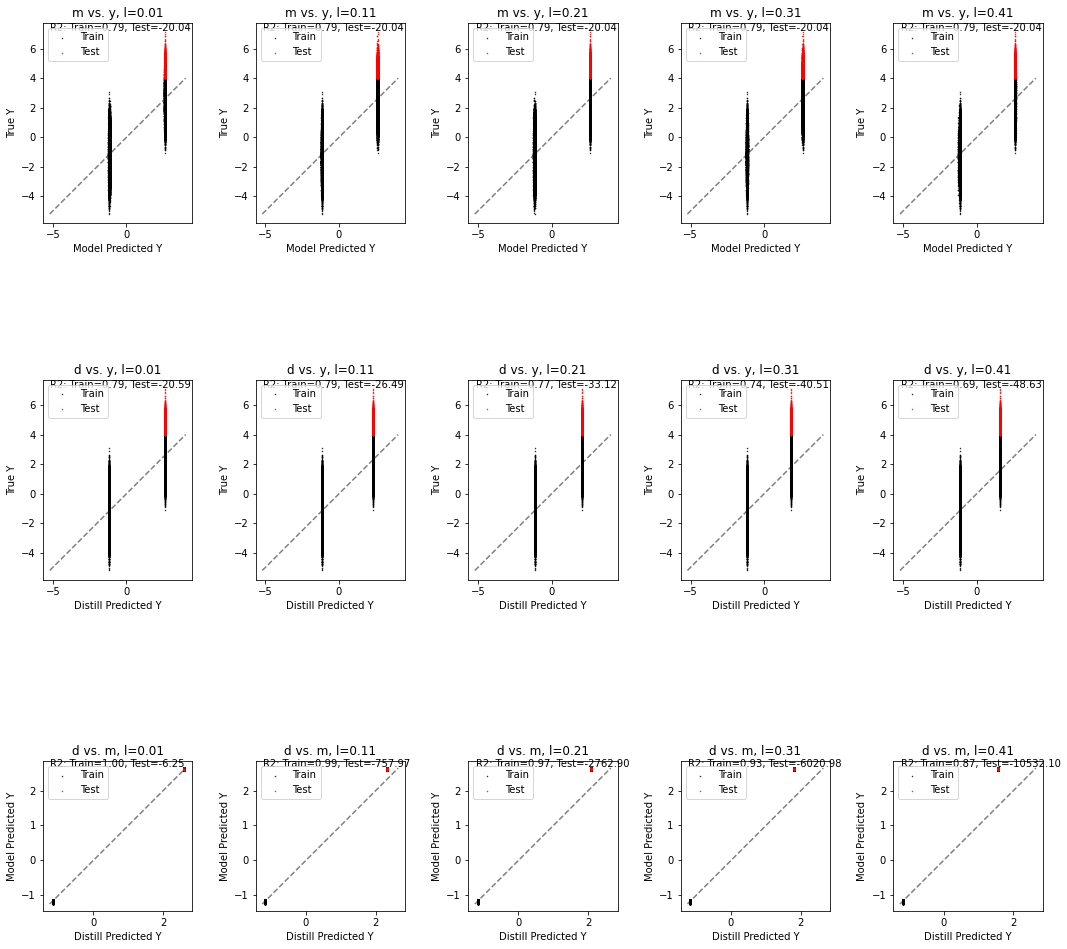

In [41]:
evaluate_model(X_train, y_train, X_test, y_test, rf, 'L1', np.around(np.arange(0.01, 0.50, 0.1), decimals=2), model_name = 'RF,d=1');

In [16]:
#evaluate_model(X_train, y_train, X_test, y_test, rf, 'L1', np.around(np.arange(0.01, 0.50, 0.1), decimals=2), 
#               use_model = False, y_pred_train = y_pred_train_mlp, y_pred_test = y_pred_test_mlp, model_name = 'MLP');

In [17]:
l0learn.fit(X.to_numpy().astype(float), y, penalty="L0L2")

NameError: name 'y' is not defined